# Assignment 3: Build Non-Linear Models – Notebook

This notebook contains:

- Applied Question 8 (a–f) from ISLR Python  
- Two Abalone models (regularized regression and PCR) for Kaggle submission  


## Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)


## Applied Question 8(a): Generate X and noise ε

In [14]:
# 8(a) Generate X and noise epsilon, n = 100
n = 100
X = np.random.normal(size=n)
eps = np.random.normal(scale=1.0, size=n)

print("First 10 values of X:")
print(X[:10])
print("\nFirst 10 values of eps:")
print(eps[:10])


First 10 values of X:
[-1.0856306   0.99734545  0.2829785  -1.50629471 -0.57860025  1.65143654
 -2.42667924 -0.42891263  1.26593626 -0.8667404 ]

First 10 values of eps:
[ 0.64205469 -1.97788793  0.71226464  2.59830393 -0.02462598  0.03414213
  0.17954948 -1.86197571  0.42614664 -1.60540974]


## Applied Question 8(b): Generate Y using cubic model

In [15]:
# 8(b) Generate Y = β0 + β1 X + β2 X^2 + β3 X^3 + ε

beta0 = 1
beta1 = 2
beta2 = 3
beta3 = 4

Y = beta0 + beta1 * X + beta2 * (X**2) + beta3 * (X**3) + eps

# create polynomial predictors X^1 ... X^10
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(X.reshape(-1, 1))
poly_cols = [f"X{i}" for i in range(1, 11)]
df_poly = pd.DataFrame(X_poly, columns=poly_cols)

print("First 5 rows of polynomial predictor matrix:")
print(df_poly.head())


First 5 rows of polynomial predictor matrix:
         X1        X2        X3        X4        X5         X6         X7  \
0 -1.085631  1.178594 -1.279518  1.389083 -1.508031   1.637165  -1.777356   
1  0.997345  0.994698  0.992057  0.989424  0.986798   0.984178   0.981565   
2  0.282978  0.080077  0.022660  0.006412  0.001815   0.000513   0.000145   
3 -1.506295  2.268924 -3.417668  5.148015 -7.754428  11.680454 -17.594206   
4 -0.578600  0.334778 -0.193703  0.112076 -0.064847   0.037521  -0.021710   

          X8         X9        X10  
0   1.929553  -2.094781   2.274159  
1   0.978960   0.976361   0.973769  
2   0.000041   0.000012   0.000003  
3  26.502059 -39.919911  60.131151  
4   0.012561  -0.007268   0.004205  


### Helper Functions for Stepwise Selection

In [16]:
def calculate_rss(model, X, y):
    preds = model.predict(X)
    return np.sum((y - preds)**2)

def forward_stepwise(X, y):
    remaining = list(X.columns)
    selected = []
    models = []

    while remaining:
        rss_list = []
        for var in remaining:
            predictors = selected + [var]
            lm = LinearRegression().fit(X[predictors], y)
            rss = calculate_rss(lm, X[predictors], y)
            rss_list.append((rss, var, predictors, lm))
        best_rss, best_var, best_pred, best_model = min(rss_list, key=lambda x: x[0])
        selected.append(best_var)
        remaining.remove(best_var)
        models.append((list(selected), best_rss, best_model))
    return models

def backward_stepwise(X, y):
    selected = list(X.columns)
    models = []

    while len(selected) > 0:
        rss_list = []
        for var in selected:
            trial = [v for v in selected if v != var]
            if not trial:
                lm = LinearRegression().fit(X[selected], y)
                rss = calculate_rss(lm, X[selected], y)
                rss_list.append((rss, None, list(selected), lm))
            else:
                lm = LinearRegression().fit(X[trial], y)
                rss = calculate_rss(lm, X[trial], y)
                rss_list.append((rss, var, list(trial), lm))
        best_rss, removed, best_pred, best_model = min(rss_list, key=lambda x: x[0])
        models.append((list(best_pred), best_rss, best_model))
        if removed is None:
            break
        selected.remove(removed)
    return models


## Applied Question 8(c): Forward Stepwise Selection

In [17]:
# 8(c) Forward stepwise selection using X1 ... X10

fwd_models = forward_stepwise(df_poly, Y)

# choose model with smallest RSS as approximation to Cp-based choice
best_fwd = min(fwd_models, key=lambda x: x[1])
best_fwd_predictors, best_fwd_rss, best_fwd_model = best_fwd

print("Forward Stepwise Selected Predictors (approx Cp):")
print(best_fwd_predictors)
print("\nForward model coefficients (including intercept):")
print([best_fwd_model.intercept_] + list(best_fwd_model.coef_))


Forward Stepwise Selected Predictors (approx Cp):
['X3', 'X2', 'X1', 'X7', 'X10', 'X6', 'X9', 'X4', 'X8', 'X5']

Forward model coefficients (including intercept):
[np.float64(1.104588359466403), np.float64(4.046942427337782), np.float64(1.824954452936657), np.float64(2.1151709430889585), np.float64(0.031178989877454554), np.float64(-0.006519037015505686), np.float64(-0.6897976469084676), np.float64(-0.0019710196828176124), np.float64(1.5972609987753947), np.float64(0.1155541355619909), np.float64(-0.12376067397824232)]


## Applied Question 8(d): Backward Stepwise Selection

In [18]:
# 8(d) Backward stepwise selection using X1 ... X10

bwd_models = backward_stepwise(df_poly, Y)

# choose model with smallest RSS
best_bwd = min(bwd_models, key=lambda x: x[1])
best_bwd_predictors, best_bwd_rss, best_bwd_model = best_bwd

print("Backward Stepwise Selected Predictors (approx Cp):")
print(best_bwd_predictors)
print("\nBackward model coefficients (including intercept):")
print([best_bwd_model.intercept_] + list(best_bwd_model.coef_))


Backward Stepwise Selected Predictors (approx Cp):
['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X10']

Backward model coefficients (including intercept):
[np.float64(1.0993139771027067), np.float64(2.174862012357655), np.float64(1.89226299313194), np.float64(3.8997233025200813), np.float64(1.4899470498957772), np.float64(-0.02384185483873066), np.float64(-0.6325842749254406), np.float64(0.00664902848955691), np.float64(0.10347195706955616), np.float64(-0.00564012540222601)]


## Applied Question 8(e): Lasso with Cross Validation

Lasso selected coefficients:
X1     0.000000
X2     0.000000
X3     0.000000
X4     0.000000
X5     0.000000
X6     0.000000
X7     0.271679
X8     0.019014
X9    -0.020878
X10    0.000000
dtype: float64


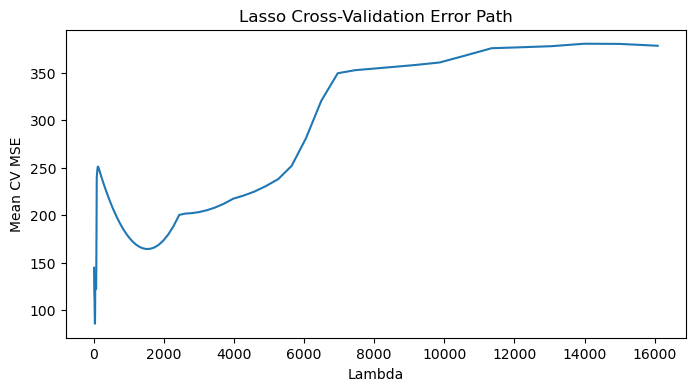

In [19]:
# 8(e) Lasso model using X1 ... X10

lasso = LassoCV(cv=10, random_state=123)
lasso.fit(df_poly, Y)

lasso_coefs = pd.Series(lasso.coef_, index=df_poly.columns)
print("Lasso selected coefficients:")
print(lasso_coefs)

plt.figure(figsize=(8,4))
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis=1))
plt.xlabel("Lambda")
plt.ylabel("Mean CV MSE")
plt.title("Lasso Cross-Validation Error Path")
plt.show()


## Applied Question 8(f): Alternative Model Y = β₀ + β₇ X⁷ + ε

In [20]:
# 8(f) New model: Y_alt = β0 + β7 X^7 + eps

beta0_alt = 1
beta7_alt = 10

Y_alt = beta0_alt + beta7_alt * (X**7) + eps

# Forward stepwise on Y_alt
fwd_alt_models = forward_stepwise(df_poly, Y_alt)
best_fwd_alt = min(fwd_alt_models, key=lambda x: x[1])
best_fwd_alt_predictors, best_fwd_alt_rss, best_fwd_alt_model = best_fwd_alt

print("Forward Stepwise Selected Predictors for Y_alt:")
print(best_fwd_alt_predictors)

# Lasso on Y_alt
lasso_alt = LassoCV(cv=10, random_state=123)
lasso_alt.fit(df_poly, Y_alt)
lasso_alt_coefs = pd.Series(lasso_alt.coef_, index=df_poly.columns)

print("\nLasso Coefficients for Y_alt:")
print(lasso_alt_coefs)


Forward Stepwise Selected Predictors for Y_alt:
['X7', 'X5', 'X1', 'X10', 'X8', 'X4', 'X6', 'X2', 'X9', 'X3']

Lasso Coefficients for Y_alt:
X1     0.000000
X2     0.000000
X3     0.000000
X4     0.000000
X5     0.000000
X6     0.000000
X7     0.000000
X8     0.000000
X9     1.287159
X10    0.000000
dtype: float64


# Abalone Kaggle Models

This section builds two models using the Kaggle Abalone dataset:

- A regularized regression model (Ridge)  
- A principal components regression (PCR) model  

Both models:

- Use one-hot encoding for the Sex variable  
- Use train.csv for training and test.csv for prediction  
- Clip negative predictions to zero to satisfy MSLE  
- Generate separate Kaggle submission files  


## Load train.csv and test.csv

In [21]:
# Update these paths if your files are stored elsewhere
train = pd.read_csv('/Users/abigailalbury-bloom/Downloads/train.csv')
test = pd.read_csv('/Users/abigailalbury-bloom/Downloads/test.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Train columns:", train.columns.tolist())


Train shape: (90615, 10)
Test shape: (60411, 9)
Train columns: ['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings']


## Preprocessing: One-Hot Encode Sex and Align Columns

In [22]:
# Separate target and features
y_train = train['Rings']
X_train = train.drop(columns=['Rings'])

# One-hot encode Sex using pandas.get_dummies
X_train_dum = pd.get_dummies(X_train, columns=['Sex'], drop_first=True)
X_test_dum = pd.get_dummies(test, columns=['Sex'], drop_first=True)

# Align columns in case some categories are missing in test
X_train_dum, X_test_dum = X_train_dum.align(X_test_dum, join='left', axis=1, fill_value=0)

print("Encoded train columns:", X_train_dum.columns.tolist())


Encoded train columns: ['id', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Sex_I', 'Sex_M']


## Model 1: Regularized Regression (Ridge)

In [23]:
# Standardize + RidgeCV
ridge_scaler = StandardScaler()
X_train_scaled = ridge_scaler.fit_transform(X_train_dum)
X_test_scaled = ridge_scaler.transform(X_test_dum)

ridge = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
ridge.fit(X_train_scaled, y_train)

ridge_pred = ridge.predict(X_test_scaled)
ridge_pred = np.maximum(ridge_pred, 0)  # clip negatives

print("Ridge alpha selected:", ridge.alpha_)
print("First 10 Ridge predictions (clipped):")
print(ridge_pred[:10])

# Create Kaggle submission file for regularized model
sub_reg = pd.DataFrame({'id': test['id'], 'Rings': ridge_pred})
sub_reg.to_csv('abalone_regularized.csv', index=False)

print("\nSaved abalone_regularized.csv for Kaggle submission.")


Ridge alpha selected: 2.023589647725158
First 10 Ridge predictions (clipped):
[ 8.51308162 10.00665704 10.28233    10.93188897  7.75904457  9.63489889
 12.87044962  6.21137981  7.77861508 11.46983529]

Saved abalone_regularized.csv for Kaggle submission.


## Model 2: Principal Components Regression (PCR)

In [24]:
# Standardize for PCA
pca_scaler = StandardScaler()
X_train_scaled_pca = pca_scaler.fit_transform(X_train_dum)

# Cross-validate number of components
max_components = min(X_train_scaled_pca.shape[1], 20)
cv = KFold(n_splits=5, shuffle=True, random_state=123)
mse_per_comp = []

for n_comp in range(1, max_components + 1):
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_train_scaled_pca)
    lm = LinearRegression()
    scores = cross_val_score(lm, X_pca, y_train, cv=cv, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    mse_per_comp.append((n_comp, mse))

best_n_comp, best_mse = min(mse_per_comp, key=lambda x: x[1])
print("Best number of components:", best_n_comp)
print("Best CV MSE:", best_mse)

# Fit final PCR model
pca_final = PCA(n_components=best_n_comp)
X_train_pca = pca_final.fit_transform(X_train_scaled_pca)
lm_final = LinearRegression()
lm_final.fit(X_train_pca, y_train)

# Transform test data
X_test_scaled_pca = pca_scaler.transform(X_test_dum)
X_test_pca = pca_final.transform(X_test_scaled_pca)

pcr_pred = lm_final.predict(X_test_pca)
pcr_pred = np.maximum(pcr_pred, 0)  # clip negatives

print("First 10 PCR predictions (clipped):")
print(pcr_pred[:10])

# Create Kaggle submission file for PCR model
sub_pcr = pd.DataFrame({'id': test['id'], 'Rings': pcr_pred})
sub_pcr.to_csv('abalone_pcr.csv', index=False)

print("\nSaved abalone_pcr.csv for Kaggle submission.")


Best number of components: 10
Best CV MSE: 3.981227439595023
First 10 PCR predictions (clipped):
[ 8.51178779 10.00607823 10.28222843 10.93256938  7.75913987  9.63463772
 12.87092589  6.21136134  7.77853918 11.46874172]

Saved abalone_pcr.csv for Kaggle submission.
